In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

/opt/anaconda3/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /Users/alirezanabaviadmin/Dropbox (ASU)/Data science/My Github/Deep_Learning/Sequence model/Sunspots.csv
100%|██████████████████████████████████████| 70.8k/70.8k [00:00<00:00, 1.83MB/s]


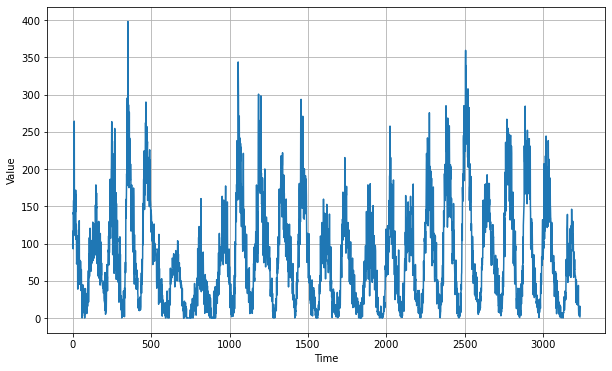

In [6]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

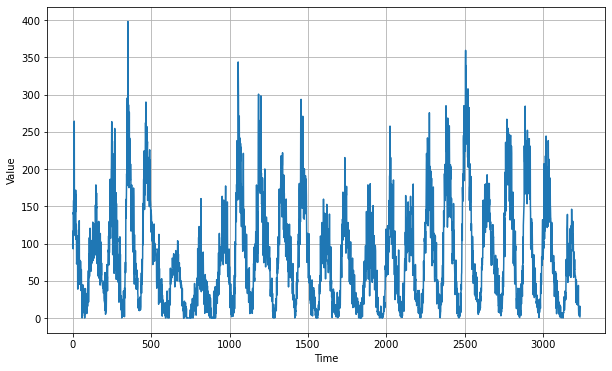

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/100
12/12 [==============================] - 6s 252ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 4s 306ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 5s 389ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 5s 407ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 6s 446ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 6s 505ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 6s 449ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [========

(1e-08, 0.0001, 0.0, 60.0)

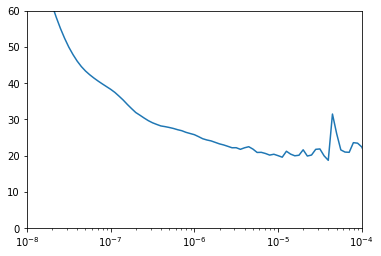

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 8s 131ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 5s 153ms/step - loss: 25.7663 - mae: 26.2608
Epoch 3/500
30/30 [==============================] - 5s 162ms/step - loss: 22.0758 - mae: 22.5696
Epoch 4/500
30/30 [==============================] - 6s 188ms/step - loss: 20.4592 - mae: 20.9521
Epoch 5/500
30/30 [==============================] - 5s 154ms/step - loss: 19.7443 - mae: 20.2368
Epoch 6/500
30/30 [==============================] - 5s 151ms/step - loss: 19.3884 - mae: 19.8806
Epoch 7/500
30/30 [==============================] - 5s 145ms/step - loss: 18.5495 - mae: 19.0414
Epoch 8/500
30/30 [==============================] - 5s 160ms/step - loss: 18.2107 - mae: 18.7023
Epoch 9/500
30/30 [==============================] - 5s 158ms/step - loss: 18.1019 - mae: 18.5935
Epoch 10/500
30/30 [==============================] - 5s 172ms/step - loss: 18.6771 - mae: 19.1686
Epoch 11/500
30/30 

30/30 [==============================] - 4s 127ms/step - loss: 15.8642 - mae: 16.3528
Epoch 166/500
30/30 [==============================] - 4s 129ms/step - loss: 15.8663 - mae: 16.3549
Epoch 167/500
30/30 [==============================] - 4s 146ms/step - loss: 15.8589 - mae: 16.3477
Epoch 168/500
30/30 [==============================] - 4s 134ms/step - loss: 15.9600 - mae: 16.4487
Epoch 169/500
30/30 [==============================] - 4s 129ms/step - loss: 15.9348 - mae: 16.4234
Epoch 170/500
30/30 [==============================] - 4s 134ms/step - loss: 15.9846 - mae: 16.4734
Epoch 171/500
30/30 [==============================] - 3s 104ms/step - loss: 16.1008 - mae: 16.5897
Epoch 172/500
30/30 [==============================] - 4s 116ms/step - loss: 15.8337 - mae: 16.3223
Epoch 173/500
30/30 [==============================] - 4s 125ms/step - loss: 15.8506 - mae: 16.3392
Epoch 174/500
30/30 [==============================] - 3s 108ms/step - loss: 16.0054 - mae: 16.4940
Epoch 175/500


30/30 [==============================] - 4s 144ms/step - loss: 15.5045 - mae: 15.9923
Epoch 248/500
30/30 [==============================] - 4s 141ms/step - loss: 15.6474 - mae: 16.1353
Epoch 249/500
30/30 [==============================] - 4s 120ms/step - loss: 15.5894 - mae: 16.0772
Epoch 250/500
30/30 [==============================] - 4s 127ms/step - loss: 15.4700 - mae: 15.9575
Epoch 251/500
30/30 [==============================] - 4s 128ms/step - loss: 15.5347 - mae: 16.0222
Epoch 252/500
30/30 [==============================] - 3s 113ms/step - loss: 15.5443 - mae: 16.0319
Epoch 253/500
30/30 [==============================] - 4s 120ms/step - loss: 15.4503 - mae: 15.9374
Epoch 254/500
30/30 [==============================] - 4s 124ms/step - loss: 15.4703 - mae: 15.9579
Epoch 255/500
30/30 [==============================] - 4s 131ms/step - loss: 15.4326 - mae: 15.9197
Epoch 256/500
30/30 [==============================] - 4s 124ms/step - loss: 15.4977 - mae: 15.9855
Epoch 257/500


30/30 [==============================] - 4s 124ms/step - loss: 15.0815 - mae: 15.5681
Epoch 330/500
30/30 [==============================] - 4s 144ms/step - loss: 15.2665 - mae: 15.7542
Epoch 331/500
30/30 [==============================] - 5s 159ms/step - loss: 15.0913 - mae: 15.5781
Epoch 332/500
30/30 [==============================] - 4s 120ms/step - loss: 15.0677 - mae: 15.5542
Epoch 333/500
30/30 [==============================] - 4s 139ms/step - loss: 15.2011 - mae: 15.6879
Epoch 334/500
30/30 [==============================] - 4s 145ms/step - loss: 15.1083 - mae: 15.5952
Epoch 335/500
30/30 [==============================] - 4s 120ms/step - loss: 15.2182 - mae: 15.7055
Epoch 336/500
30/30 [==============================] - 4s 142ms/step - loss: 15.0560 - mae: 15.5424
Epoch 337/500
30/30 [==============================] - 4s 143ms/step - loss: 15.1108 - mae: 15.5978
Epoch 338/500
30/30 [==============================] - 6s 202ms/step - loss: 15.1791 - mae: 15.6656
Epoch 339/500


30/30 [==============================] - 3s 114ms/step - loss: 15.3902 - mae: 15.8775
Epoch 412/500
30/30 [==============================] - 4s 130ms/step - loss: 14.8275 - mae: 15.3137
Epoch 413/500
30/30 [==============================] - 4s 133ms/step - loss: 14.8252 - mae: 15.3113
Epoch 414/500
30/30 [==============================] - 4s 135ms/step - loss: 14.9363 - mae: 15.4228
Epoch 415/500
30/30 [==============================] - 4s 135ms/step - loss: 14.8900 - mae: 15.3764
Epoch 416/500
30/30 [==============================] - 3s 109ms/step - loss: 15.2494 - mae: 15.7365
Epoch 417/500
30/30 [==============================] - 4s 133ms/step - loss: 14.7930 - mae: 15.2794
Epoch 418/500
30/30 [==============================] - 4s 140ms/step - loss: 14.8613 - mae: 15.3481
Epoch 419/500
30/30 [==============================] - 4s 119ms/step - loss: 14.7072 - mae: 15.1932
Epoch 420/500
30/30 [==============================] - 4s 122ms/step - loss: 14.8434 - mae: 15.3300
Epoch 421/500


30/30 [==============================] - 4s 144ms/step - loss: 14.4761 - mae: 14.9619
Epoch 494/500
30/30 [==============================] - 5s 156ms/step - loss: 14.4072 - mae: 14.8927
Epoch 495/500
30/30 [==============================] - 4s 129ms/step - loss: 14.5799 - mae: 15.0655
Epoch 496/500
30/30 [==============================] - 4s 133ms/step - loss: 14.5011 - mae: 14.9867
Epoch 497/500
30/30 [==============================] - 4s 137ms/step - loss: 14.4841 - mae: 14.9700
Epoch 498/500
30/30 [==============================] - 3s 112ms/step - loss: 14.4724 - mae: 14.9581
Epoch 499/500
30/30 [==============================] - 3s 112ms/step - loss: 14.5084 - mae: 14.9944
Epoch 500/500
30/30 [==============================] - 4s 140ms/step - loss: 14.4969 - mae: 14.9825


In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

100/100 [==============================] - 3s 18ms/step


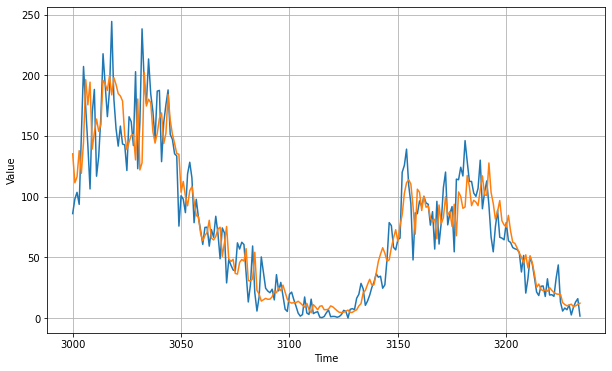

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.342973

<Figure size 432x288 with 0 Axes>

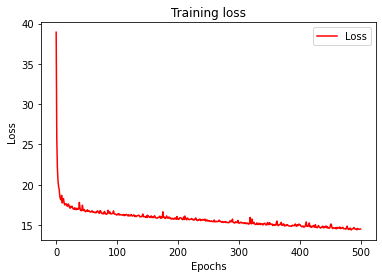

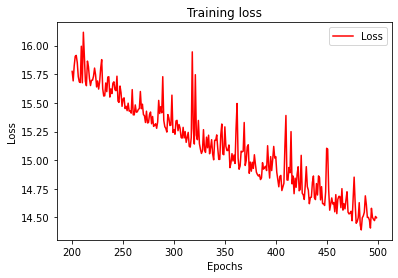

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[135.2841    111.38505   116.25832   137.86595   119.18935   145.07678
 196.34143   175.61076   194.29308   139.1101    152.86581   163.88312
 153.81548   159.23035   195.83162   192.75368   187.42453   199.61952
 183.80717   197.9244    192.3299    184.85733   182.91252   178.79709
 150.40315   138.69814   144.82458   150.54678   151.12392   130.23753
 180.42284   121.9648    127.90283   202.32951   174.66788   180.2285
 177.3866    153.58188   144.08722   152.16498   164.36673   168.94025
 143.69337   152.11147   183.99615   162.96838   151.34105   143.85242
 135.40517   134.93352   103.62687   112.48301   100.46792    92.42108
 104.80758   108.18831    96.23712    84.36843    83.46542    69.8379
  63.684536   67.98055    70.43983    80.496605   65.74065    64.28214
  67.225945   73.2777     74.75477    50.766438   61.897053   75.392105
  48.67567    46.574223   48.347546   36.718563   36.14493    45.724827
  48.13608    46.902023   57.14631    30.818323   30.517664   32.221764
  54.